# Assignment 6

In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

### Set up connection to WRDS...

In [2]:
#sign in

import wrds
db=wrds.Connection(wrds_username='anita97')
#db.create_pgpass_file()


Loading library list...
Done


### Download and format data

In [3]:
import numpy as np
import datetime
import pandas as pd
import datetime
#################################
# Get data
#################################

# get risk-free rate see http://www.crsp.com/files/treasury_guide_0.pdf
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='2000-01-01'"
            "and mcaldt<='2019-12-31'", date_cols=['mcaldt'])

#transform annualized and continuously compounded returns into simple and monthly returns:
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

#use own index instead
# get index returns
data_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='2000-01-01'"
            "and date<='2019-12-31'", date_cols=['date'])


# get stock returns
crsp_m = db.raw_sql("""
                      select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2000' and '12/31/2019'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
msf=crsp_m.drop(['shrcd','exchcd'],axis=1)
del(crsp_m) 


#################################
# Define some stuff...
#################################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

#variables
msf['permno'] = msf['permno'].astype(int)
msf['size'] = msf['shrout'] * msf['prc'].abs()
msf['const'] = 1
msf.sort_values(['permno','date'])

msf['size_lag']= msf.groupby('permno')['size'].shift(1).to_frame()

obs=msf[['const','permno']].groupby(['permno']).sum().reset_index().rename(columns={'const': 'obs'})
msf = pd.merge(msf, obs, how='left', left_on=['permno'],right_on=['permno'])



#################################
# Compute excess returns
#################################
data_index = pd.merge(data_index, Rf, how='left', left_on=['date'],right_on='date')
data_index['mprem']=(data_index['vwretd']-data_index['rf'])
data = pd.merge(msf, data_index, how='left', left_on=['date'],right_on='date')
data['exret']=data['ret']-data['rf']


print('duplicates in data on returns?')
print(data.duplicated(subset=['date','permno']).sum(),'\n')

print(' How many obervations do we have in a month?')
print('max:', max(data[['date','const']].groupby('date').sum()['const'].values))
print('min:', min(data[['date','const']].groupby('date').sum()['const'].values))

print('\n How often do we observe a given stock?')
print('max:', max(data['obs'].values))
print('min:', min(data['obs'].values))

print('\n Let us limit our attention to stocks we observe often enough...')



duplicates in data on returns?
0 

 How many obervations do we have in a month?
max: 2310
min: 1403

 How often do we observe a given stock?
max: 240
min: 1

 Let us limit our attention to stocks we observe often enough...


In [4]:
# save data
data.to_csv('data.csv', sep=';', index=False)
data_index.to_csv('data_index.csv', sep=';', index=False)
Rf.to_csv('Rf.csv', sep=';', index=False)

In case memory crashes, take a break here and load only the necessary data below...

In [36]:
import numpy as np
import pandas as pd

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
    
# load data
data = pd.read_csv("data.csv", sep=';')
data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')

data_index = pd.read_csv("data_index.csv", sep=';')
data_index['date']=pd.to_datetime(data_index['date'], format='%Y-%m-%d')

Rf = pd.read_csv("Rf.csv", sep=';')
Rf['date']=pd.to_datetime(Rf['date'], format='%Y-%m-%d')


vwrets_mkt=data[data['date']>'1972-01-31'].groupby(['date']).apply(wavg, 'exret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})
print('A quick consistency check! \n')
print('The average value-weighted excess return in the sample is ', vwrets_mkt['vwret'].mean(),'.\n')
print('The value-weighted return from CRSP is ', data_index[data_index['date']>'1972-01-31']['mprem'].values.mean(),'.\n')
print('The average risk-free rate is ', Rf['rf'].mean(),'.\n')

print('Looks alright!')

A quick consistency check! 

The average value-weighted excess return in the sample is  0.004851333880593641 .

The value-weighted return from CRSP is  0.00451006587858147 .

The average risk-free rate is  0.0013152996576685284 .

Looks alright!


In [37]:
data['prc']=np.abs(data['prc'])

### Calculate betas for the whole sample period, get portfolio returns

In [38]:
#################################
# drop stocks with fewer than 24 observations in total
#################################
data=data[data.obs>=240]

#data = data[(data['ret'].notnull()) & (data['size_lag'].notnull())]

print(' How many obervations do we have now in a year?')
print('max:', max(data[['date','const']].groupby('date').sum()['const'].values))
print('min:', min(data[['date','const']].groupby('date').sum()['const'].values))

print('\n How often do we observe a given stock now?')
print('max:', max(data['obs'].values))
print('min:', min(data['obs'].values))

#drop some stuff that is not needed anymore
data=data.drop(['size','shrout','prc'],axis=1)


 How many obervations do we have now in a year?
max: 639
min: 639

 How often do we observe a given stock now?
max: 240
min: 240


In [39]:
#################################
# Compute betas
#################################

############ for the whole sample #############################
covariances=data.groupby('permno')['exret'].cov(data['mprem']).to_frame().reset_index().rename(columns={'exret': 'covar'})
mvar=data.groupby('permno')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})

#merge new values with original dataset
data = pd.merge(data, covariances, how='left', left_on=['permno'],right_on='permno')
data = pd.merge(data, mvar, how='left', left_on=['permno'],right_on='permno')

# cumpute the betas
data['beta']=data['covar']/data['varm']

#drop some stuff that is not needed anymore
data=data.drop(['covar','vwretd', 'varm'],axis=1)


In [40]:
data.head()

,permno,date,ret,const,size_lag,obs,rf,mprem,exret,beta
0,10145,2000-01-31,-0.167931,1,NaN,240,0.004498,-0.044123,-0.172429,1.19749
1,10145,2001-07-31,0.059088,1,3.788318e+07,240,0.003038,-0.021336,0.056050,1.19749
2,10145,2001-08-31,0.015663,1,2.983819e+07,240,0.002816,-0.061797,0.012848,1.19749
3,10145,2001-09-28,-0.291465,1,3.024081e+07,240,0.001983,-0.093468,-0.293449,1.19749
4,10145,2001-10-31,0.119318,1,2.142666e+07,240,0.001746,0.026090,0.117572,1.19749


In [41]:
################# rolling windows ####################

# in order to keep track of the dates, it is convenient to define an index
data = data.sort_values(['permno', 'date'])
data=data.set_index('date')

# rolling covariances
covariances_rolling=data.groupby('permno')['exret','mprem'].rolling(24).cov().reset_index()


covariances_rolling=covariances_rolling[covariances_rolling.level_2=='exret']
covariances_rolling=covariances_rolling.drop(['exret','level_2'],axis=1)



covariances_rolling=covariances_rolling.rename(columns={"mprem": "cov_real"})


#rolling variances
mvar_rolling=data.groupby('permno')['mprem'].rolling(24).var().reset_index()
mvar_rolling=mvar_rolling.rename(columns={"mprem": "var_real"})

# convert data back to what we had before
data=data.reset_index()

#merge new values with original dataset
data = pd.merge(data, covariances_rolling, how='left', left_on=['permno','date'],right_on=['permno','date'])
data = pd.merge(data, mvar_rolling, how='left', left_on=['permno','date'],right_on=['permno','date'])

# cumpute the betas
data['beta_real']=data['cov_real']/data['var_real']


### for the portfolio formation, we need the lagged beta...
data.sort_values(['permno', 'date'])
data['beta_real_lag'] = data.groupby('permno')['beta_real'].shift(1)


# save data
data.to_csv('data_wbetas.csv', sep=';', index=False)

#drop some stuff that is not needed anymore
data=data.drop(['beta_real'],axis=1)


# drop all observations with missing values
data_real=data[(data['ret'].notnull())&(data['size_lag'].notnull())&(data['beta_real_lag'].notnull())&(data['date']>'1972-01-31')].copy()
data=data[(data['ret'].notnull())&(data['size_lag'].notnull())&(data['beta'].notnull())&(data['date']>'1972-01-31')]



C:\Users\Administrator\Anaconda3\envs\investments\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [43]:
data.head()

,date,permno,ret,const,size_lag,obs,rf,mprem,exret,beta,cov_real,var_real,beta_real_lag,decile
0,2000-01-31,11404,-0.052536,1,2.350175e+07,240,0.004498,-0.044123,-0.057035,0.053210,NaN,NaN,NaN,1
1,2000-01-31,11674,0.098814,1,7.019965e+06,240,0.004498,-0.044123,0.094316,0.310257,NaN,NaN,NaN,1
2,2000-01-31,12781,-0.127168,1,4.246894e+06,240,0.004498,-0.044123,-0.131666,0.160945,NaN,NaN,NaN,1
3,2000-01-31,13688,0.070122,1,5.625260e+06,240,0.004498,-0.044123,0.065624,0.344781,NaN,NaN,NaN,1
4,2000-01-31,15720,0.122482,1,4.919746e+06,240,0.004498,-0.044123,0.117984,0.340234,NaN,NaN,NaN,1


In [45]:

#################################
# Compute deciles
#################################

#msf_dec = msf_dec.sort_values(['date'])
#msf_dec['decile']=1+msf_dec.groupby('date')['size']\
#.transform(lambda x: pd.qcut(x, 10, labels=False))
# here conpute deciles for whole sample period...

#this considers beta in the entire sample period
#data['decile']=1+data['beta']\
#.transform(lambda x: pd.qcut(x, 10, labels=False))

# better look at deciles in a given month
data['decile']=1+data[['beta','date']].groupby('date')\
.transform(lambda x: pd.qcut(x, 10, labels=False))

#do the same for the lagged and rolling betas
data_real['decile_real']=1+data_real[['beta_real_lag','date']].groupby('date')\
.transform(lambda x: pd.qcut(x, 10, labels=False))



In [46]:
data.head()

,date,permno,ret,const,size_lag,obs,rf,mprem,exret,beta,cov_real,var_real,beta_real_lag,decile
0,2000-01-31,11404,-0.052536,1,2.350175e+07,240,0.004498,-0.044123,-0.057035,0.053210,NaN,NaN,NaN,1
1,2000-01-31,11674,0.098814,1,7.019965e+06,240,0.004498,-0.044123,0.094316,0.310257,NaN,NaN,NaN,1
2,2000-01-31,12781,-0.127168,1,4.246894e+06,240,0.004498,-0.044123,-0.131666,0.160945,NaN,NaN,NaN,1
3,2000-01-31,13688,0.070122,1,5.625260e+06,240,0.004498,-0.044123,0.065624,0.344781,NaN,NaN,NaN,1
4,2000-01-31,15720,0.122482,1,4.919746e+06,240,0.004498,-0.044123,0.117984,0.340234,NaN,NaN,NaN,1


In [48]:

#################################
# Compute Size Weighted Returns #
#################################

data = data.sort_values(['decile', 'date'])
data.head()
data_real = data_real.sort_values(['decile_real', 'date'])

    
# in order to keep track of the dates, it is convenient to define an index

data=data.set_index('date')    

data_real = data_real.sort_values(['decile_real', 'date'])
data_real=data_real.set_index('date')    


# value-weigthed return
vwrets=data.groupby(['decile','date']).apply(wavg, 'ret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})
vwrets_real=data_real.groupby(['decile_real','date']).apply(wavg, 'ret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})



# convert data back to what we had before
data=data.reset_index()
data_real=data_real.reset_index()


#################################
# Compute Equally Weighted Returns #
#################################

data.head()

data = data.sort_values(['decile', 'date'])
data_real = data_real.sort_values(['decile_real', 'date'])
# in order to keep track of the dates, it is convenient to define an index
data_real=data_real.set_index('date')  
data=data.set_index('date')  


# equally weigthed return
ewrets=data.groupby(['decile','date']).apply(wavg, 'ret','const')\
.to_frame().reset_index().rename(columns={0: 'ewret'})

ewrets_real=data_real.groupby(['decile_real','date']).apply(wavg, 'ret','const')\
.to_frame().reset_index().rename(columns={0: 'ewret'})

# convert data back to what we had before
data=data.reset_index()
data_real=data_real.reset_index()


In [49]:
#################################
# Compute Portfolio Returns #
#################################


HML_ret_vw=vwrets.loc[vwrets.decile ==10]['vwret'].values-vwrets.loc[vwrets.decile ==1]['vwret'].values
HML_ret_ew=ewrets.loc[ewrets.decile ==10]['ewret'].values-ewrets.loc[ewrets.decile ==1]['ewret'].values


HML_ret_vw_real=vwrets_real.loc[vwrets_real.decile_real ==10]['vwret'].values-vwrets_real.loc[vwrets_real.decile_real ==1]['vwret'].values
HML_ret_ew_real=ewrets_real.loc[ewrets_real.decile_real ==10]['ewret'].values-ewrets_real.loc[ewrets_real.decile_real ==1]['ewret'].values


#correl_vw=np.corrcoef(HML_ret_vw[0:-1],HML_ret_vw[1:])[0,1]
#correl_ew=np.corrcoef(HML_ret_ew[0:-1],HML_ret_ew[1:])[0,1]

print('\n')
print('Using value-weighted returns, the mean is ', np.mean(HML_ret_vw),'.')
#print('Its t-stat is ', np.mean(HML_ret_vw)/np.std(HML_ret_vw)*np.sqrt(len(HML_ret_vw))*np.sqrt(1-correl_vw),'.\n')
# might as well assume zero autocorrelation...
print('Its t-stat is ', np.mean(HML_ret_vw)/np.std(HML_ret_vw)*np.sqrt(len(HML_ret_vw)),'.\n')

print('Using equally weighted returns, the mean is ', np.mean(HML_ret_ew),'.')
#print('Its t-stat is ', np.mean(HML_ret_ew)/np.std(HML_ret_ew)*np.sqrt(len(HML_ret_ew))*np.sqrt(1-correl_ew),'.')
print('Its t-stat is ', np.mean(HML_ret_ew)/np.std(HML_ret_ew)*np.sqrt(len(HML_ret_ew)),'.')

print('\n')
print('Now do the same thing with the actual trading strategies')
print('\n')

print('Using value-weighted returns, the mean is ', np.mean(HML_ret_vw_real),'.')
#print('Its t-stat is ', np.mean(HML_ret_vw)/np.std(HML_ret_vw)*np.sqrt(len(HML_ret_vw))*np.sqrt(1-correl_vw),'.\n')
# might as well assume zero autocorrelation...
print('Its t-stat is ', np.mean(HML_ret_vw_real)/np.std(HML_ret_vw_real)*np.sqrt(len(HML_ret_vw_real)),'.\n')

print('Using equally weighted returns, the mean is ', np.mean(HML_ret_ew_real),'.')
#print('Its t-stat is ', np.mean(HML_ret_ew)/np.std(HML_ret_ew)*np.sqrt(len(HML_ret_ew))*np.sqrt(1-correl_ew),'.')
print('Its t-stat is ', np.mean(HML_ret_ew_real)/np.std(HML_ret_ew_real)*np.sqrt(len(HML_ret_ew_real)),'.')


#save important stuff to a .csv file
vwrets.to_csv('vwrets.csv', sep=';', index=False)
vwrets_real.to_csv('vwrets_real.csv', sep=';', index=False)
ewrets.to_csv('ewrets.csv', sep=';', index=False)
ewrets_real.to_csv('ewrets_real.csv', sep=';', index=False)
#data = pd.read_csv("test.csv", sep=';')   

# Need to remember to reformat dates when loading data from .csv file
#vwrets = pd.read_csv("vwrets.csv", sep=';')
#vwrets['date']=pd.to_datetime(vwrets['date'], format='%Y-%m-%d')




Using value-weighted returns, the mean is  -0.0053734088348757585 .
Its t-stat is  -1.1199748166746832 .

Using equally weighted returns, the mean is  0.002462951263286391 .
Its t-stat is  0.4160014465397628 .


Now do the same thing with the actual trading strategies


Using value-weighted returns, the mean is  0.0035645614069657995 .
Its t-stat is  0.7067107775858363 .

Using equally weighted returns, the mean is  0.009011754302663929 .
Its t-stat is  1.8114718900156033 .


### How are the returns related to the betas?

C:\Users\Administrator\Anaconda3\envs\investments\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\Administrator\Anaconda3\envs\investments\lib\site-packages\ipykernel_launcher.py:57: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\Administrator\Anaconda3\envs\investments\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\Administrator\Anaconda3\envs\investments\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



 (a) betas and returns: whole sample and equally-weighted returns:


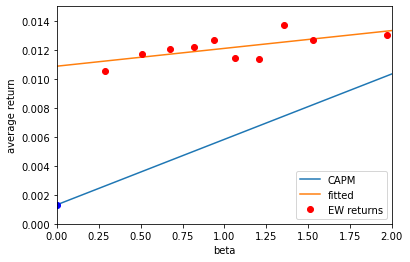

The market risk premium is  0.00451006587858147 .

The actual slope is  0.001228056015452042 .


 (b) betas and returns: out of sample trading and equally-weighted returns:


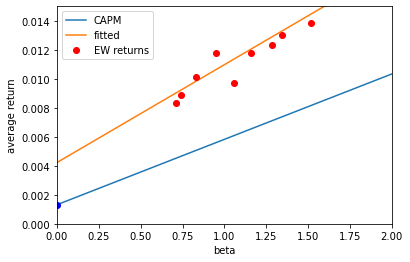

The market risk premium is  0.00451006587858147 .

The actual slope is  0.006749222969061075 .


 (c) betas and returns: whole sample and value weighted returns:


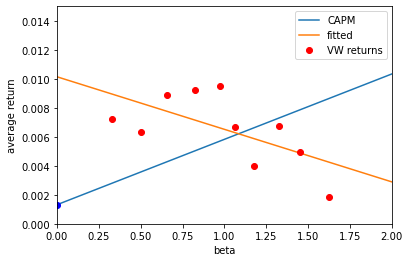

The market risk premium is  0.00451006587858147 .

The actual slope is  -0.003625118487671087 .


 (d) betas and returns: out of sample trading and value weighted returns:


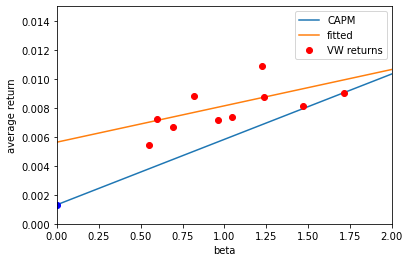

The market risk premium is  0.00451006587858147 .

The actual slope is  0.002506325294962797 .



In [50]:
# load data, remember to reformat the dates...
vwrets = pd.read_csv("vwrets.csv", sep=';')
vwrets['date']=pd.to_datetime(vwrets['date'], format='%Y-%m-%d')

vwrets_real = pd.read_csv("vwrets_real.csv", sep=';')
vwrets_real['date']=pd.to_datetime(vwrets_real['date'], format='%Y-%m-%d')

ewrets = pd.read_csv("ewrets.csv", sep=';')
ewrets['date']=pd.to_datetime(ewrets['date'], format='%Y-%m-%d')

ewrets_real = pd.read_csv("ewrets_real.csv", sep=';')
ewrets_real['date']=pd.to_datetime(ewrets_real['date'], format='%Y-%m-%d')


# add the market risk premium to the datasets
vwrets=pd.merge(vwrets, data_index[['date','mprem']], how='left', left_on=['date'],right_on=['date'])
vwrets_real=pd.merge(vwrets_real, data_index[['date','mprem']], how='left', left_on=['date'],right_on=['date'])
ewrets=pd.merge(ewrets, data_index[['date','mprem']], how='left', left_on=['date'],right_on=['date'])
ewrets_real=pd.merge(ewrets_real, data_index[['date','mprem']], how='left', left_on=['date'],right_on=['date'])

# add therisk-free rate to the datasets
vwrets=pd.merge(vwrets, Rf[['date','rf']], how='left', left_on=['date'],right_on=['date'])
vwrets_real=pd.merge(vwrets_real, Rf[['date','rf']], how='left', left_on=['date'],right_on=['date'])
ewrets=pd.merge(ewrets, Rf[['date','rf']], how='left', left_on=['date'],right_on=['date'])
ewrets_real=pd.merge(ewrets_real, Rf[['date','rf']], how='left', left_on=['date'],right_on=['date'])

# in the following, consider excess returns
vwrets['vwexret']=vwrets['vwret']-vwrets['rf']
vwrets=vwrets.drop(['rf'],axis=1)

vwrets_real['vwexret']=vwrets_real['vwret']-vwrets_real['rf']
vwrets_real=vwrets_real.drop(['rf'],axis=1)

ewrets['ewexret']=ewrets['ewret']-ewrets['rf']
ewrets=ewrets.drop(['rf'],axis=1)

ewrets_real['ewexret']=ewrets_real['ewret']-ewrets_real['rf']
ewrets_real=ewrets_real.drop(['rf'],axis=1)



###### VW ####################
covariances=vwrets.groupby('decile')['vwret'].cov(vwrets['mprem']).to_frame().reset_index().rename(columns={'vwret': 'covar'})
mvar=vwrets.groupby('decile')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=vwrets.groupby('decile')['vwret','vwexret','mprem'].mean().reset_index().rename(columns={'vwret': 'meanret','vwexret': 'meanexret'})
#merge stuff
vwdata = pd.merge(covariances, mvar, how='left', left_on=['decile'],right_on='decile')
vwdata = pd.merge(vwdata, meanret, how='left', left_on=['decile'],right_on='decile')
# cumpute the betas
vwdata['beta']=vwdata['covar']/vwdata['varm']
#drop some stuff that is not needed anymore
vwdata=vwdata.drop(['covar', 'varm'],axis=1)

###### VW_real ####################
covariances=vwrets_real.groupby('decile_real')['vwret'].cov(vwrets_real['mprem']).to_frame().reset_index().rename(columns={'vwret': 'covar'})
mvar=vwrets_real.groupby('decile_real')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=vwrets_real.groupby('decile_real')['vwret','vwexret','mprem'].mean().reset_index().rename(columns={'vwret': 'meanret','vwexret': 'meanexret'})
#merge stuff
vwdata_real = pd.merge(covariances, mvar, how='left', left_on=['decile_real'],right_on='decile_real')
vwdata_real = pd.merge(vwdata_real, meanret, how='left', left_on=['decile_real'],right_on='decile_real')
# cumpute the betas
vwdata_real['beta']=vwdata_real['covar']/vwdata_real['varm']
#drop some stuff that is not needed anymore
vwdata_real=vwdata_real.drop(['covar', 'varm'],axis=1)

###### EW ####################
covariances=ewrets.groupby('decile')['ewret'].cov(ewrets['mprem']).to_frame().reset_index().rename(columns={'ewret': 'covar'})
mvar=ewrets.groupby('decile')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=ewrets.groupby('decile')['ewret','ewexret','mprem'].mean().reset_index().rename(columns={'ewret': 'meanret','ewexret': 'meanexret'})
#merge stuff
ewdata = pd.merge(covariances, mvar, how='left', left_on=['decile'],right_on='decile')
ewdata = pd.merge(ewdata, meanret, how='left', left_on=['decile'],right_on='decile')
# cumpute the betas
ewdata['beta']=ewdata['covar']/ewdata['varm']
#drop some stuff that is not needed anymore
ewdata=ewdata.drop(['covar', 'varm'],axis=1)

###### EW_real ####################
covariances=ewrets_real.groupby('decile_real')['ewret'].cov(ewrets_real['mprem']).to_frame().reset_index().rename(columns={'ewret': 'covar'})
mvar=ewrets_real.groupby('decile_real')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=ewrets_real.groupby('decile_real')['ewret','ewexret','mprem'].mean().reset_index().rename(columns={'ewret': 'meanret','ewexret': 'meanexret'})
#merge stuff
ewdata_real = pd.merge(covariances, mvar, how='left', left_on=['decile_real'],right_on='decile_real')
ewdata_real = pd.merge(ewdata_real, meanret, how='left', left_on=['decile_real'],right_on='decile_real')
# cumpute the betas
ewdata_real['beta']=ewdata_real['covar']/ewdata_real['varm']
#drop some stuff that is not needed anymore
ewdata_real=ewdata_real.drop(['covar', 'varm'],axis=1)


#################################
# Fama-McBeth #
#################################
import statsmodels.formula.api as sm

### VW    ####
result1 = sm.ols(formula="meanexret ~ beta", data=vwdata).fit()
### VW_real    ####
result2 = sm.ols(formula="meanexret ~ beta", data=vwdata_real).fit()
### EW   ####
result3 = sm.ols(formula="meanexret ~ beta", data=ewdata).fit()
### EW_real    ####
result4 = sm.ols(formula="meanexret ~ beta", data=ewdata_real).fit()



#make plots of returns vs. beta
import matplotlib.pyplot as plt
R0=Rf[Rf['date']>'1972-01-31']['rf'].mean()
MP=data_index[data_index['date']>'1972-01-31']['mprem'].values.mean()

beta_values = np.linspace(0,2,100)




# first plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result3.params.values[0]+result3.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(ewdata['beta'].values,ewdata['meanret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(0, 0.015)
plt.legend(['CAPM','fitted','EW returns'], loc=0)
print('\n (a) betas and returns: whole sample and equally-weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result3.params.values[1],'.\n')

# second plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result4.params.values[0]+result4.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(ewdata_real['beta'].values,ewdata_real['meanret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(0, 0.015)
plt.legend(['CAPM','fitted','EW returns'], loc=0)
print('\n (b) betas and returns: out of sample trading and equally-weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result4.params.values[1],'.\n')

# thrid plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result1.params.values[0]+result1.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(vwdata['beta'].values,vwdata['meanret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(0, 0.015)
plt.legend(['CAPM','fitted','VW returns'], loc=0)
print('\n (c) betas and returns: whole sample and value weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result1.params.values[1],'.\n')

# fourth plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result2.params.values[0]+result2.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(vwdata_real['beta'].values,vwdata_real['meanret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(0, 0.015)
plt.legend(['CAPM','fitted','VW returns'], loc=0)
print('\n (d) betas and returns: out of sample trading and value weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result2.params.values[1],'.\n')

### Now look at size

In [5]:
# load the old dataset and drop observations with no returns or no lagged sizes
# load data
data = pd.read_csv("data.csv", sep=';')
data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data[(data['ret'].notnull())&(data['size_lag'].notnull())&(data['date']>'1970-01-31')].copy()


# the following code is smilar to what we had before...

#################################
# Compute deciles
#################################


# look at deciles in a given month
data['decile']=1+data[['size_lag','date']].groupby('date')\
.transform(lambda x: pd.qcut(x, 10, labels=False))


#################################
# Compute Size Weighted Returns #
#################################

data = data.sort_values(['decile', 'date'])
 
# in order to keep track of the dates, it is convenient to define an index

data=data.set_index('date')    

# value-weigthed return
vwrets_size=data.groupby(['decile','date']).apply(wavg, 'ret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})


# convert data back to what we had before
data=data.reset_index()


#################################
# Compute Equally Weighted Returns #
#################################

data = data.sort_values(['decile', 'date'])

# in order to keep track of the dates, it is convenient to define an index

data=data.set_index('date')  


# equally weigthed return
ewrets_size=data.groupby(['decile','date']).apply(wavg, 'ret','const')\
.to_frame().reset_index().rename(columns={0: 'ewret'})


# convert data back to what we had before
data=data.reset_index()


#################################
# Compute Portfolio Returns #
#################################


HML_ret_vw=vwrets_size.loc[vwrets_size.decile ==1]['vwret'].values-vwrets_size.loc[vwrets_size.decile ==10]['vwret'].values
HML_ret_ew=ewrets_size.loc[ewrets_size.decile ==1]['ewret'].values-ewrets_size.loc[ewrets_size.decile ==10]['ewret'].values


#correl_vw=np.corrcoef(HML_ret_vw[0:-1],HML_ret_vw[1:])[0,1]
#correl_ew=np.corrcoef(HML_ret_ew[0:-1],HML_ret_ew[1:])[0,1]

print('\n')
print('Using value-weighted returns, the mean is ', np.mean(HML_ret_vw),'.')
#print('Its t-stat is ', np.mean(HML_ret_vw)/np.std(HML_ret_vw)*np.sqrt(len(HML_ret_vw))*np.sqrt(1-correl_vw),'.\n')
# might as well assume zero autocorrelation...
print('Its t-stat is ', np.mean(HML_ret_vw)/np.std(HML_ret_vw)*np.sqrt(len(HML_ret_vw)),'.\n')

print('Using equally weighted returns, the mean is ', np.mean(HML_ret_ew),'.')
#print('Its t-stat is ', np.mean(HML_ret_ew)/np.std(HML_ret_ew)*np.sqrt(len(HML_ret_ew))*np.sqrt(1-correl_ew),'.')
print('Its t-stat is ', np.mean(HML_ret_ew)/np.std(HML_ret_ew)*np.sqrt(len(HML_ret_ew)),'.')




Using value-weighted returns, the mean is  0.00336761725868 .
Its t-stat is  1.17701421083 .

Using equally weighted returns, the mean is  0.0089268784814 .
Its t-stat is  2.88468670331 .



 (a) statistics for value-weighted returns:


size quintile,1,2,3,4,5,6,7,8,9,10
Mean Return,0.011945,0.009084,0.009628,0.011520,0.011291,0.011457,0.011228,0.011015,0.010605,0.008578
Std. Dev.,0.081002,0.070843,0.066517,0.065715,0.063096,0.059570,0.054292,0.051607,0.048628,0.041457
Ann. Sharpe Ratio,0.507089,0.440450,0.497644,0.603503,0.616161,0.662469,0.712632,0.735643,0.751749,0.712979



 (a) statistics for equally weighted returns:


size quintile,1,2,3,4,5,6,7,8,9,10
Mean Return,0.018116,0.008802,0.009718,0.011548,0.011314,0.011453,0.011281,0.011084,0.010597,0.009189
Std. Dev.,0.087905,0.070838,0.066710,0.065847,0.063121,0.059762,0.054541,0.051748,0.048985,0.043547
Ann. Sharpe Ratio,0.710139,0.426668,0.500894,0.603772,0.617167,0.660097,0.712730,0.738204,0.745627,0.727201



 (a) betas and returns: whole sample and value weighted returns:


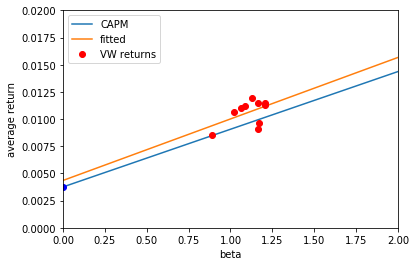

The market risk premium is  0.00530436235105 .

The actual slope is  0.00565456314415 .


 (b) betas and returns: whole sample and equally-weighted returns:


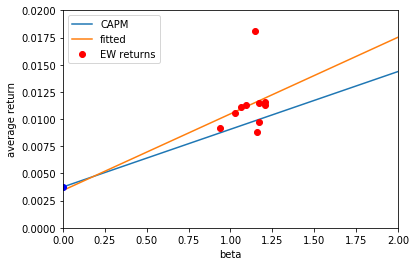

The market risk premium is  0.00530436235105 .

The actual slope is  0.00703737083728 .



In [6]:
#################################
# Compute betas #
#################################
###### VW ####################
vwrets_size=pd.merge(vwrets_size, data_index[['date','rf','mprem']], how='left', left_on=['date'],right_on=['date'])
vwrets_size['vwexret']=vwrets_size['vwret']-vwrets_size['rf']
#vwrets_size=vwrets_size.drop(['rf'],axis=1)

covariances=vwrets_size.groupby('decile')['vwret'].cov(vwrets_size['mprem']).to_frame().reset_index().rename(columns={'vwret': 'covar'})
mvar=vwrets_size.groupby('decile')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=vwrets_size.groupby('decile')['vwret','vwexret','mprem'].mean().reset_index().rename(columns={'vwret': 'meanret','vwexret': 'meanexret'})

#merge stuff
vwdata_size = pd.merge(covariances, mvar, how='left', left_on=['decile'],right_on='decile')
vwdata_size = pd.merge(vwdata_size, meanret, how='left', left_on=['decile'],right_on='decile')
# cumpute the betas
vwdata_size['beta']=vwdata_size['covar']/vwdata_size['varm']
#drop some stuff that is not needed anymore
vwdata_size=vwdata_size.drop(['covar', 'varm'],axis=1)


###### EW ####################
ewrets_size=pd.merge(ewrets_size, data_index[['date','rf','mprem']], how='left', left_on=['date'],right_on=['date'])
ewrets_size['ewexret']=ewrets_size['ewret']-ewrets_size['rf']
#ewrets_size=ewrets_size.drop(['rf'],axis=1)

covariances=ewrets_size.groupby('decile')['ewret'].cov(ewrets_size['mprem']).to_frame().reset_index().rename(columns={'ewret': 'covar'})
mvar=ewrets_size.groupby('decile')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=ewrets_size.groupby('decile')['ewret','ewexret','mprem'].mean().reset_index().rename(columns={'ewret': 'meanret','ewexret': 'meanexret'})

#merge stuff
ewdata_size = pd.merge(covariances, mvar, how='left', left_on=['decile'],right_on='decile')
ewdata_size = pd.merge(ewdata_size, meanret, how='left', left_on=['decile'],right_on='decile')
# cumpute the betas
ewdata_size['beta']=ewdata_size['covar']/ewdata_size['varm']
#drop some stuff that is not needed anymore
ewdata_size=ewdata_size.drop(['covar', 'varm'],axis=1)



################################### Plots ########################################

# VW
R0=vwrets_size.groupby('decile')['rf'].mean().reset_index().rename(columns={'vwret': 'meanret'})['rf'].values
E =vwrets_size.groupby('decile')['vwret'].mean().reset_index().rename(columns={'vwret': 'meanret'})['meanret'].values
S = vwrets_size.groupby('decile')['vwret'].std().reset_index().rename(columns={'vwret': 'meanret'})['meanret'].values

SR = E/S*np.sqrt(12)-R0
index = ['Mean Return', 'Std. Dev.', 'Ann. Sharpe Ratio']
pStats = pd.DataFrame({index[0] : E, 
                    index[1] : S, 
                    index[2] : SR,
                       'size quintile': [1,2,3,4,5,6,7,8,9,10]
                      })
pStats = pStats.set_index('size quintile')
pStats = pStats.T
pStats = pStats.reindex(index)

print('\n (a) statistics for value-weighted returns:')
display(np.around(pStats,6))

# EW and whole sample
R0=ewrets_size.groupby('decile')['rf'].mean().reset_index().rename(columns={'ewret': 'meanret'})['rf'].values
E =ewrets_size.groupby('decile')['ewret'].mean().reset_index().rename(columns={'ewret': 'meanret'})['meanret'].values
S = ewrets_size.groupby('decile')['ewret'].std().reset_index().rename(columns={'ewret': 'meanret'})['meanret'].values

SR = E/S*np.sqrt(12)-R0
index = ['Mean Return', 'Std. Dev.', 'Ann. Sharpe Ratio']
pStats = pd.DataFrame({index[0] : E, 
                    index[1] : S, 
                    index[2] : SR,
                       'size quintile': [1,2,3,4,5,6,7,8,9,10]
                      })
pStats = pStats.set_index('size quintile')
pStats = pStats.T
pStats = pStats.reindex(index)

print('\n (a) statistics for equally weighted returns:')
display(np.around(pStats,6))





#make plots of returns vs. beta
import matplotlib.pyplot as plt
R0=Rf[Rf['date']>'1970-01-31']['rf'].mean()
MP=data_index[data_index['date']>'1970-01-31']['mprem'].values.mean()

beta_values = np.linspace(0,2,100)

# first plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result1.params.values[0]+result1.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(vwdata_size['beta'].values,vwdata_size['meanret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(0, 0.02)
plt.legend(['CAPM','fitted','VW returns'], loc=0)
print('\n (a) betas and returns: whole sample and value weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result1.params.values[1],'.\n')

# second plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result2.params.values[0]+result2.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(ewdata_size['beta'].values,ewdata_size['meanret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(0, 0.02)
plt.legend(['CAPM','fitted','EW returns'], loc=0)
print('\n (b) betas and returns: whole sample and equally-weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result2.params.values[1],'.\n')


### Now do some double-sorting

In [7]:
import numpy as np
import pandas as pd

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
    
# load data
data = pd.read_csv("data_wbetas.csv", sep=';')
data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')
data=data.drop(['var_real','cov_real','obs','beta_real'],axis=1)
data_index = pd.read_csv("data_index.csv", sep=';')
data_index['date']=pd.to_datetime(data_index['date'], format='%Y-%m-%d')



# look at size deciles in a given month

#drop observations with missing values
data=data[(data['ret'].notnull())&(data['beta'].notnull())&(data['ret'].notnull())&(data['size_lag'].notnull())&(data['beta_real_lag'].notnull())&(data['date']>'1972-01-31')].copy()


data['quintile_size']=1+data[['size_lag','date']].groupby('date')\
.transform(lambda x: pd.qcut(x, 5, labels=False))

# look at beta deciles in a given month and for a given size decile
data['quintile_beta']=1+data[['beta','date','quintile_size']].groupby(['date','quintile_size'])\
.transform(lambda x: pd.qcut(x, 5, labels=False))

data['quintile_beta_real']=1+data[['beta_real_lag','date','quintile_size']].groupby(['date','quintile_size'])\
.transform(lambda x: pd.qcut(x, 5, labels=False))

# in order to keep track of the dates, it is convenient to define an index

data=data.set_index('date')    
data = data.sort_values(['quintile_size','quintile_beta'])


# value-weigthed return
vwrets=data.groupby(['quintile_size','quintile_beta','date']).apply(wavg, 'ret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})
# equally weigthed return
ewrets=data.groupby(['quintile_size','quintile_beta','date']).apply(wavg, 'ret','const')\
.to_frame().reset_index().rename(columns={0: 'ewret'})

data = data.sort_values(['quintile_size','quintile_beta_real'])

# value-weigthed return
vwrets_real=data.groupby(['quintile_size','quintile_beta_real','date']).apply(wavg, 'ret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})
# equally weigthed return
ewrets_real=data.groupby(['quintile_size','quintile_beta_real','date']).apply(wavg, 'ret','const')\
.to_frame().reset_index().rename(columns={0: 'ewret'})

# convert data back to what we had before
data=data.reset_index()
#################################
# Compute Portfolio Returns #
#################################

# VW whole sample
HML_ret_vw=vwrets.loc[vwrets.quintile_beta ==5][['date','vwret','quintile_size']]
HML_ret_vw=pd.merge(HML_ret_vw, vwrets.loc[vwrets.quintile_beta ==1][['date','vwret','quintile_size']], how='left', left_on=['quintile_size','date'],right_on=['quintile_size','date'])
HML_ret_vw['HML']=HML_ret_vw['vwret_x']-HML_ret_vw['vwret_y']
HML_ret_vw=HML_ret_vw.drop(['vwret_x','vwret_y'],axis=1)
HML_mean_vw=HML_ret_vw.groupby('quintile_size')['HML'].mean().values
HML_std_vw=HML_ret_vw.groupby('quintile_size')['HML'].std().values
#N=len(HML_ret_vw['HML'].values)/5
N=12 # annualize the sharpe ratio

# EW whole sample
HML_ret_ew=ewrets.loc[ewrets.quintile_beta ==5][['date','ewret','quintile_size']]
HML_ret_ew=pd.merge(HML_ret_ew, ewrets.loc[ewrets.quintile_beta ==1][['date','ewret','quintile_size']], how='left', left_on=['quintile_size','date'],right_on=['quintile_size','date'])
HML_ret_ew['HML']=HML_ret_ew['ewret_x']-HML_ret_ew['ewret_y']
HML_ret_ew=HML_ret_ew.drop(['ewret_x','ewret_y'],axis=1)
HML_mean_ew=HML_ret_ew.groupby('quintile_size')['HML'].mean().values
HML_std_ew=HML_ret_ew.groupby('quintile_size')['HML'].std().values


# VW trading strategy
HML_ret_vw_real=vwrets_real.loc[vwrets_real.quintile_beta_real ==5][['date','vwret','quintile_size']]
HML_ret_vw_real=pd.merge(HML_ret_vw_real, vwrets.loc[vwrets_real.quintile_beta_real ==1][['date','vwret','quintile_size']], how='left', left_on=['quintile_size','date'],right_on=['quintile_size','date'])
HML_ret_vw_real['HML']=HML_ret_vw_real['vwret_x']-HML_ret_vw_real['vwret_y']
HML_ret_vw_real=HML_ret_vw_real.drop(['vwret_x','vwret_y'],axis=1)
HML_mean_vw_real=HML_ret_vw_real.groupby('quintile_size')['HML'].mean().values
HML_std_vw_real=HML_ret_vw_real.groupby('quintile_size')['HML'].std().values


# EW trading strategy
HML_ret_ew_real=ewrets.loc[ewrets_real.quintile_beta_real ==5][['date','ewret','quintile_size']]
HML_ret_ew_real=pd.merge(HML_ret_ew_real, ewrets_real.loc[ewrets_real.quintile_beta_real ==1][['date','ewret','quintile_size']], how='left', left_on=['quintile_size','date'],right_on=['quintile_size','date'])
HML_ret_ew_real['HML']=HML_ret_ew_real['ewret_x']-HML_ret_ew_real['ewret_y']
HML_ret_ew_real=HML_ret_ew_real.drop(['ewret_x','ewret_y'],axis=1)
HML_mean_ew_real=HML_ret_ew_real.groupby('quintile_size')['HML'].mean().values
HML_std_ew_real=HML_ret_ew_real.groupby('quintile_size')['HML'].std().values

# EW and whole sample
E = HML_mean_ew
S = HML_std_ew
SR = E/S*np.sqrt(12)
index = ['Mean Excess Return', 'Std. Dev.', 'Ann. Sharpe Ratio']
pStats = pd.DataFrame({index[0] : E, 
                    index[1] : S, 
                    index[2] : SR,
                       'size quintile': [1,2,3,4,5]
                      })
pStats = pStats.set_index('size quintile')
pStats = pStats.T
pStats = pStats.reindex(index)

print('\n (a) statistics for equally weighted returns and whole sample:')
display(np.around(pStats,6))


# EW and trading strategy
E = HML_mean_ew_real
S = HML_std_ew_real
SR = E/S*np.sqrt(12)
index = ['Mean Excess Return', 'Std. Dev.', 'Ann. Sharpe Ratio']
pStats = pd.DataFrame({index[0] : E, 
                    index[1] : S, 
                    index[2] : SR,
                       'size quintile': [1,2,3,4,5]
                      })
pStats = pStats.set_index('size quintile')
pStats = pStats.T
pStats = pStats.reindex(index)

print('\n (b) statistics for equally weighted returns and trading strategy:')
display(np.around(pStats,6))


# VW and whole sample
E = HML_mean_vw
S = HML_std_vw
SR = E/S*np.sqrt(12)
index = ['Mean Excess Return', 'Std. Dev.', 'Ann. Sharpe Ratio']
pStats = pd.DataFrame({index[0] : E, 
                    index[1] : S, 
                    index[2] : SR,
                       'size quintile': [1,2,3,4,5]
                      })
pStats = pStats.set_index('size quintile')
pStats = pStats.T
pStats = pStats.reindex(index)

print('\n (c) statistics for value-weighted returns and whole sample:')
display(np.around(pStats,6))


# VW and trading strategy
E = HML_mean_vw_real
S = HML_std_vw_real
SR = E/S*np.sqrt(12)
index = ['Mean Excess Return', 'Std. Dev.', 'Ann. Sharpe Ratio']
pStats = pd.DataFrame({index[0] : E, 
                    index[1] : S, 
                    index[2] : SR,
                       'size quintile': [1,2,3,4,5]
                      })
pStats = pStats.set_index('size quintile')
pStats = pStats.T
pStats = pStats.reindex(index)

print('\n (d) statistics for value-weighted returns and trading strategy:')
display(np.around(pStats,6))



 (a) statistics for equally weighted returns and whole sample:


size quintile,1,2,3,4,5
Mean Excess Return,0.004438,0.001655,-0.000697,-0.000629,-0.002179
Std. Dev.,0.098264,0.070500,0.063039,0.058906,0.054615
Ann. Sharpe Ratio,0.156444,0.081334,-0.038323,-0.036969,-0.138238



 (b) statistics for equally weighted returns and trading strategy:


size quintile,1,2,3,4,5
Mean Excess Return,0.003067,0.001637,0.000055,0.000084,-0.001563
Std. Dev.,0.074122,0.058240,0.053928,0.051784,0.049417
Ann. Sharpe Ratio,0.143322,0.097338,0.003542,0.005597,-0.109578



 (c) statistics for value-weighted returns and whole sample:


size quintile,1,2,3,4,5
Mean Excess Return,0.002225,0.001829,-0.000822,-0.000550,-0.002655
Std. Dev.,0.091011,0.070063,0.062779,0.058697,0.051592
Ann. Sharpe Ratio,0.084687,0.090450,-0.045365,-0.032461,-0.178240



 (d) statistics for value-weighted returns and trading strategy:


size quintile,1,2,3,4,5
Mean Excess Return,-0.001182,0.000746,-0.001132,-0.000713,-0.001590
Std. Dev.,0.071341,0.059826,0.056958,0.055143,0.048008
Ann. Sharpe Ratio,-0.057382,0.043212,-0.068865,-0.044781,-0.114742


### Look at the relationship with the CAPM beta...


 (a) betas and returns: whole sample and equally-weighted returns:


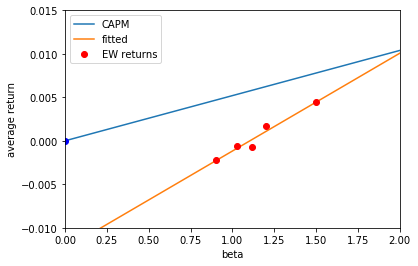

The market risk premium is  0.0051955359764 .

The actual slope is  0.0112465128379 .


 (b) betas and returns: out of sample trading and equally-weighted returns:


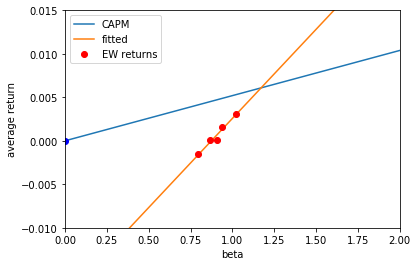

The market risk premium is  0.0051955359764 .

The actual slope is  0.0204918867758 .


 (c) betas and returns: whole sample and value weighted returns:


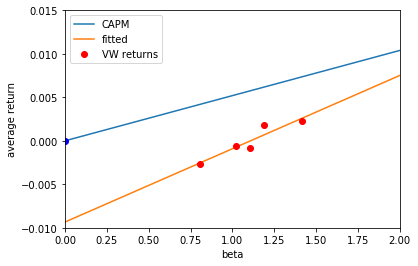

The market risk premium is  0.0051955359764 .

The actual slope is  0.00842700804357 .


 (d) betas and returns: out of sample trading and value weighted returns:


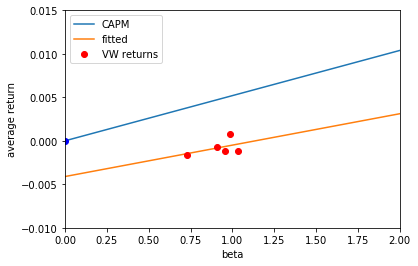

The market risk premium is  0.0051955359764 .

The actual slope is  0.00361160834037 .



In [8]:
# add the market risk premium to the datasets
HML_ret_vw=pd.merge(HML_ret_vw, data_index[['date','mprem']], how='left', left_on=['date'],right_on=['date'])
HML_ret_vw_real=pd.merge(HML_ret_vw_real, data_index[['date','mprem']], how='left', left_on=['date'],right_on=['date'])
HML_ret_ew=pd.merge(HML_ret_ew, data_index[['date','mprem']], how='left', left_on=['date'],right_on=['date'])
HML_ret_ew_real=pd.merge(HML_ret_ew_real, data_index[['date','mprem']], how='left', left_on=['date'],right_on=['date'])


###### VW ####################
covariances=HML_ret_vw.groupby('quintile_size')['HML'].cov(HML_ret_vw['mprem']).to_frame().reset_index().rename(columns={'HML': 'covar'})
mvar=HML_ret_vw.groupby('quintile_size')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=HML_ret_vw.groupby('quintile_size')['HML','mprem'].mean().reset_index().rename(columns={'HML': 'meanexret'})
#merge stuff
vwdata = pd.merge(covariances, mvar, how='left', left_on=['quintile_size'],right_on='quintile_size')
vwdata = pd.merge(vwdata, meanret, how='left', left_on=['quintile_size'],right_on='quintile_size')
# cumpute the betas
vwdata['beta']=vwdata['covar']/vwdata['varm']
#drop some stuff that is not needed anymore
vwdata=vwdata.drop(['covar', 'varm'],axis=1)

###### EW ####################
covariances=HML_ret_ew.groupby('quintile_size')['HML'].cov(HML_ret_ew['mprem']).to_frame().reset_index().rename(columns={'HML': 'covar'})
mvar=HML_ret_ew.groupby('quintile_size')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=HML_ret_ew.groupby('quintile_size')['HML','mprem'].mean().reset_index().rename(columns={'HML': 'meanexret'})
#merge stuff
ewdata = pd.merge(covariances, mvar, how='left', left_on=['quintile_size'],right_on='quintile_size')
ewdata = pd.merge(ewdata, meanret, how='left', left_on=['quintile_size'],right_on='quintile_size')
# cumpute the betas
ewdata['beta']=ewdata['covar']/ewdata['varm']
#drop some stuff that is not needed anymore
ewdata=ewdata.drop(['covar', 'varm'],axis=1)

###### VW_real ####################
covariances=HML_ret_vw_real.groupby('quintile_size')['HML'].cov(HML_ret_vw_real['mprem']).to_frame().reset_index().rename(columns={'HML': 'covar'})
mvar=HML_ret_vw_real.groupby('quintile_size')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=HML_ret_vw_real.groupby('quintile_size')['HML','mprem'].mean().reset_index().rename(columns={'HML': 'meanexret'})
#merge stuff
vwdata_real = pd.merge(covariances, mvar, how='left', left_on=['quintile_size'],right_on='quintile_size')
vwdata_real = pd.merge(vwdata_real, meanret, how='left', left_on=['quintile_size'],right_on='quintile_size')
# cumpute the betas
vwdata_real['beta']=vwdata_real['covar']/vwdata_real['varm']
#drop some stuff that is not needed anymore
vwdata_real=vwdata_real.drop(['covar', 'varm'],axis=1)

###### EW_real ####################
covariances=HML_ret_ew_real.groupby('quintile_size')['HML'].cov(HML_ret_ew_real['mprem']).to_frame().reset_index().rename(columns={'HML': 'covar'})
mvar=HML_ret_ew_real.groupby('quintile_size')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm'})
meanret=HML_ret_ew_real.groupby('quintile_size')['HML','mprem'].mean().reset_index().rename(columns={'HML': 'meanexret'})
#merge stuff
ewdata_real = pd.merge(covariances, mvar, how='left', left_on=['quintile_size'],right_on='quintile_size')
ewdata_real = pd.merge(ewdata_real, meanret, how='left', left_on=['quintile_size'],right_on='quintile_size')
# cumpute the betas
ewdata_real['beta']=ewdata_real['covar']/ewdata_real['varm']
#drop some stuff that is not needed anymore
ewdata_real=ewdata_real.drop(['covar', 'varm'],axis=1)

#################################
# Fama-McBeth #
#################################
import statsmodels.formula.api as sm

### VW    ####
result1 = sm.ols(formula="meanexret ~ beta", data=vwdata).fit()
### VW_real    ####
result2 = sm.ols(formula="meanexret ~ beta", data=vwdata_real).fit()
### EW   ####
result3 = sm.ols(formula="meanexret ~ beta", data=ewdata).fit()
### EW_real    ####
result4 = sm.ols(formula="meanexret ~ beta", data=ewdata_real).fit()



#make plots of returns vs. beta
import matplotlib.pyplot as plt
R0=0 # we already have excess returns here...
MP=data_index[data_index['date']>'1972-01-31']['mprem'].values.mean()

beta_values = np.linspace(0,2,100)




# first plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result3.params.values[0]+result3.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(ewdata['beta'].values,ewdata['meanexret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(-0.01, 0.015)
plt.legend(['CAPM','fitted','EW returns'], loc=0)
print('\n (a) betas and returns: whole sample and equally-weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result3.params.values[1],'.\n')

# second plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result4.params.values[0]+result4.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(ewdata_real['beta'].values,ewdata_real['meanexret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(-0.01, 0.015)
plt.legend(['CAPM','fitted','EW returns'], loc=0)
print('\n (b) betas and returns: out of sample trading and equally-weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result4.params.values[1],'.\n')

# third plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result1.params.values[0]+result1.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(vwdata['beta'].values,vwdata['meanexret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(-0.01, 0.015)
plt.legend(['CAPM','fitted','VW returns'], loc=0)
print('\n (c) betas and returns: whole sample and value weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result1.params.values[1],'.\n')

# fourth plot
CAPM_line = R0+MP*beta_values
fitted_line=R0+result2.params.values[0]+result2.params.values[1]*beta_values


plt.plot(beta_values,CAPM_line)
plt.plot(beta_values,fitted_line)

plt.plot(vwdata_real['beta'].values,vwdata_real['meanexret'].values,'ro')
plt.plot(0,R0,'bo')
plt.xlabel('beta')
plt.ylabel('average return')
plt.xlim(0, 2)
plt.ylim(-0.01, 0.015)
plt.legend(['CAPM','fitted','VW returns'], loc=0)
print('\n (d) betas and returns: out of sample trading and value weighted returns:')
plt.show()
print('The market risk premium is ',MP ,'.\n')
print('The actual slope is ',result2.params.values[1],'.\n')
